In [1]:
!pip install photutils

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table, Column
from astropy.visualization import ZScaleInterval
import astropy.time
import pandas as pd
import glob 
import scipy.signal
import scipy.ndimage.interpolation as interp
import shutil
import pdb
import photutils
import astropy.stats as stat
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from photutils.utils import calc_total_error
import os

from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder

In [3]:
#Load in the image
hdu = fits.open('C:/Users/amh77/Desktop/Documents/astrometry/new-image.fits')
w = WCS(hdu[0].header)

image = hdu[0].data

#Load in the target list
targ = ascii.read('C:/Users/amh77/Desktop/Documents/astrometry/asu.txt', data_start=3, delimiter=';')
targ['_RA'].name = 'RA'
targ['_DE'].name = 'Dec'

#Put RA/Dec into an array
sky = np.array([list(targ['RA']), list(targ['Dec'])]).T

In [4]:
targ

CSI,n_CSI,2MASS,CoRoT,Jmag,Hmag,Kmag,[3.6],[4.5],[5.8],Class,SpT,EWHa,C,Simbad,F,OPer,IPer,Ovar,Ivar,S,u_S,RA,Dec
int32,str1,str17,int32,float64,float64,float64,float64,float64,float64,str6,str4,float64,str1,str6,str1,str2,str2,str3,str3,float64,str1,float64,float64
7,--,J06415304+0958028,223994721,12.22,11.53,11.18,10.12,9.74,9.32,II,K7,--,Y,Simbad,e,AP,AP,B,S,2.94,*,100.471,9.96744
11,--,J06411725+0954323,223985009,12.83,12.05,11.55,10.49,10.07,9.69,II,K7,58.3,N,Simbad,--,AP,AP,S,L,2.75,--,100.32187,9.90897
12,--,J06410934+0956081,602099712,11.91,10.57,10.0,9.54,9.31,9.01,II,K5,2.33,Y,Simbad,--,QP,AP,QPS,U,0.65,*,100.28892,9.93558
21,--,J06405944+0959454,223980412,12.78,12.09,11.69,11.25,10.94,10.71,II,K5,7.41,N,Simbad,--,QP,AP,QPD,L,0.44,--,100.24767,9.99594
24,--,J06415684+0947451,603414392,14.74,14.07,13.81,13.61,13.55,13.39,II/III,--,--,Y,Simbad,--,N,N,N,N,0.0,--,100.48683,9.79586
56,--,J06415315+0950474,223994760,12.96,12.3,12.0,11.72,11.39,11.04,II,K5,1.8,N,Simbad,--,QP,AP,QPD,L,0.02,--,100.47146,9.8465
58,--,J06420870+0941212,616895632,--,--,--,11.68,11.27,11.24,flat,--,94.0,N,Simbad,--,QP,AP,QPS,U,-0.02,--,100.53625,9.68922
63,--,J06411193+0959412,616826518,14.2,13.52,--,12.81,12.58,12.21,II,M2.5,19.35,N,Simbad,--,N,AP,N,U,-0.01,--,100.29971,9.99478
90,I,J06410896+0933460,616919796,12.96,12.14,--,11.37,11.08,10.65,II,M3,51.0,N,Simbad,e,AP,AP,U,L,0.02,--,100.28733,9.56278


In [5]:
#Transform the RA and Dec into pixel coordinates.
pos = np.array(w.wcs_world2pix(sky[:,0], sky[:,1], 0)).T
aperture = photutils.CircularAperture(pos, r=10)
pos_x = []
pos_y = []
for i in np.arange(len(pos)):
    pos_x.append(pos[i][0])
    pos_y.append(pos[i][1])

<ipython-input-6-957ce6e74da7>:5: RuntimeWarning: divide by zero encountered in log10
  mn, mx = ZScaleInterval().get_limits(np.log10(image))
<ipython-input-6-957ce6e74da7>:14: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(image), origin = 'lower', vmin = mn, vmax = mx)


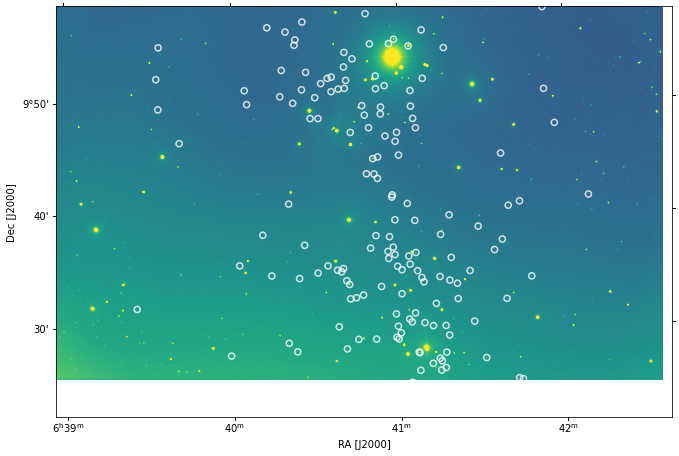

In [6]:
#Plot the apertures
%matplotlib inline

#Scale your image to something reasonble.
mn, mx = ZScaleInterval().get_limits(np.log10(image))

plt.figure(figsize = [10,7])

#Use the wcs solution to use sky coordinates when plotting. 
ax = plt.subplot(projection = w)
plt.subplots_adjust(right = 0.98, top = 0.98)

#Plot the apertures.
ax.imshow(np.log10(image), origin = 'lower', vmin = mn, vmax = mx)
aperture.plot(color='w', lw=1.5, alpha=0.8)

ax.set_xlabel('RA [J2000]')
ax.set_ylabel('Dec [J2000]')


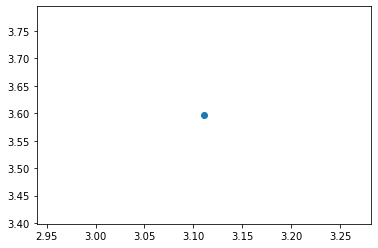

In [7]:
plt.scatter(mn, mx)

In [8]:
yuh = np.arange(10)
yuh1 = np.arange(10)

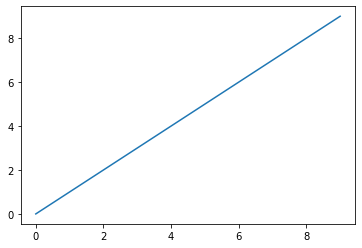

In [9]:
plt.plot(yuh, yuh1)

In [10]:
def measurePhotometry(fitsfile, star_xpos, star_ypos, aperture_radius, sky_inner, sky_outer, error_array):
    """
    This function takes a fitsfile, positions of stars, an aperture radius, annuli specifications, and an error image
    and outputs a photometry table for the image.
    """
    
    
    # Read in the data from the fits file:
    image = fits.getdata(fitsfile)
    mn, mx = ZScaleInterval().get_limits(image)#helps to get good size for a figure
    #Creates the aperture (around the stars) and the annulus (a shell around the aperture, for bkg calcs)
    #Makes a list of apertures and annuli for each star
    #starapertures = CircularAperture((star_xpos, star_ypos),r = aperture_radius)
    pos = [(star_xpos[i],star_ypos[i]) for i in np.arange(len(star_xpos))]
    starapertures = CircularAperture(pos,r = aperture_radius)
    skyannuli = CircularAnnulus(pos, r_in = sky_inner, r_out = sky_outer)
    phot_apers = [starapertures, skyannuli]
    plt.imshow(image, vmin = mn, vmax = mx)# added variables at end related to automatic scaling and zscaleinterval
    aperture.plot(color='w', lw=1.5, alpha=0.8)
    
    # What is new about the way we're calling aperture_photometry?
    # Last time, we didn't have an error array to pass to the function. This time, our calculations will be more accurate because they consider 
    # median background AND noise 
    phot_table = aperture_photometry(image, phot_apers, error=error_array)
        
    # Calculate mean background in annulus and subtract from aperture flux
    bkg_mean = phot_table['aperture_sum_1'] / skyannuli.area
    bkg_starap_sum = bkg_mean * starapertures.area
    final_sum = phot_table['aperture_sum_0']-bkg_starap_sum
    phot_table['bg_subtracted_star_counts'] = final_sum
    
    # Calculating the mean error in the background. First, the error in the sum of values within the aperture
    #is divided by the area of the annulus to compute the mean error from the background. Sum error is computed by 
    #multiplying this by the area of the apertures - this is the total flux error within the aperture
    bkg_mean_err = phot_table['aperture_sum_err_1'] / skyannuli.area
    bkg_sum_err = bkg_mean_err * starapertures.area
    
    # Propagating the error to find the total error: taking the square root of the sum of the squares of the Poisson noise and the background error calculated above
    phot_table['bg_sub_star_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2)) 
    
    return phot_table

In [11]:
def bg_error_estimate(fitsfile):
    """
    This function takes a .fits file as an input, gets the data from the file, masks data greater than 3
    standard deviations from the median, replaces the masked data with NaNs, and calculates the median of this 
    error. Then, it writes two files, a background error file and a total error file, the latter considering the
    gain of the observing device (and thus Poisson noise). It outputs the raw data of the error_image.
    """
    fitsdata = fits.getdata(fitsfile) #gets the data from a .fits file
    hdr = fits.getheader(fitsfile) #saves the header as hdr
    
    # What is happening in the next step? Read the docstring for sigma_clip.
    # Answer: takes the median of the data and iterates over the data, rejecting values that are more than
    #3 standard deviations (sigma=3) away from the median. Returns an array with the same shape, with the 
    #rejected data masked 

    filtered_data = sigma_clip(fitsdata, sigma=3.,copy=False)
    
    # Summarize the following steps:
    # Takes the masked array and fills all the maxed points with a specified value, in this case a NaN
    # the background error = the square root of the above result
    # takes every nan point in the above line's output and sets it to the median of the bakground error
    bkg_values_nan = filtered_data.filled(fill_value=np.nan)
    bkg_error = np.sqrt(bkg_values_nan)
    bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)
    
    print("Writing the background-only error image: ", fitsfile.split('.')[0]+"_bgerror.fit")
    fits.writeto(fitsfile.split('.')[0]+"_bgerror.fit", bkg_error, hdr, overwrite=True)
    
    effective_gain = 1.4 # electrons per ADU
    
    error_image = calc_total_error(fitsdata, bkg_error, effective_gain)  
    
    print("Writing the total error image: ", fitsfile.split('.')[0]+"_error.fit")
    fits.writeto(fitsfile.split('.')[0]+"_error.fit", error_image, hdr, overwrite=True)
    
    return error_image

In [12]:
error_array = bg_error_estimate('C:/Users/amh77/Desktop/Documents/astrometry/new-image.fits')

Writing the background-only error image:  C:/Users/amh77/Desktop/Documents/astrometry/new-image_bgerror.fit
Writing the total error image:  C:/Users/amh77/Desktop/Documents/astrometry/new-image_error.fit


In [13]:
%matplotlib

table = measurePhotometry('C:/Users/amh77/Desktop/Documents/astrometry/new-image.fits', pos_x, pos_y, 10, 15, 20, error_array)

Using matplotlib backend: Qt5Agg


In [25]:
table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aper_sum_bkgsub,err,SNR
,pix,pix,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
59,1146.891589822561,522.8715160528575,679533.5053325596,1079.3120867340003,1539876.154900591,1513.538459704944,-200395.72603920684,1383.0872974944255,-144.89015003047163
68,1159.404729050995,111.98096966114218,151938.94004447878,880.8273882453343,563812.2818040294,1277.771421359727,-170239.50670068085,1144.1081045519404,-148.79669676612477
47,1045.1889224303695,845.2689841365535,627096.6475963371,1036.8330745355609,1163869.379792041,1389.9014409815463,-37971.569427686394,1306.0716504423704,-29.073113572923287
63,945.0216775552333,442.5689116843276,714590.7817535426,1106.8029493637785,1312544.2686406681,1478.4200882371415,-35434.514612553525,1392.3789727506344,-25.44890098602459
33,984.3096615778127,251.5404535265093,774566.6470806214,1149.4600132427174,1409270.853838223,1529.9738047659157,-30730.983684077626,1444.1633074627925,-21.27943808381891
34,1080.600589089568,1214.298026789179,879078.5150178024,1150.7249954090503,1586656.0471651237,1545.7083946244522,-27582.0833622684,1450.6273364764047,-19.013900171815106
152,825.5135436448129,970.3805567963482,644596.2174899527,1051.200307803243,1155628.6979083514,1400.1563554800102,-15763.038457676768,1321.0469517356537,-11.93223180823857
21,1170.022964470026,534.3745214369186,700583.115338735,1087.7752143070884,1241281.143964835,1439.955284620991,-8720.395498313592,1363.9306230000468,-6.393577027497602


In [20]:
table['bg_sub_star_cts_err'].name='err'

In [24]:
table['bg_subtracted_star_counts'].name='aper_sum_bkgsub'
table['SNR'] = table['aper_sum_bkgsub']/table['err']

KeyError: 'bg_subtracted_star_counts'

In [26]:
table = table[['id', 'xcenter', 'ycenter', 'aper_sum_bkgsub', 'err', 'SNR']]

In [31]:
namelist = glob.glob('C:/Users/amh77/Desktop/Documents/astrometry/new-image.fits')

In [32]:
ascii.write(table, namelist[0][:-5]+'.dat', names=['id', 'xcenter', 'ycenter', 'aper_sum_bkgsub', 'err', 'SNR'],overwrite=True)

In [30]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 5EB9-6C51

 Directory of C:\Users\amh77\Desktop\Documents

04/22/2021  02:51 PM    <DIR>          .
04/22/2021  02:51 PM    <DIR>          ..
04/22/2021  11:30 AM    <DIR>          .ipynb_checkpoints
04/22/2021  02:29 PM    <DIR>          astrometry
04/22/2021  02:51 PM           289,195 astrometry.ipynb
04/15/2021  06:45 AM             6,656 astrometry.py
04/22/2021  10:48 AM    <DIR>          Bias
04/18/2021  10:54 PM            29,442 csi 2264 list of objects.txt
04/22/2021  10:48 AM    <DIR>          Darks
04/19/2021  07:08 PM    <DIR>          data for ensemble photeometry
04/15/2021  05:07 PM            48,186 Data-Reduction + Aligning Combining Pipeline(1).ipynb
04/15/2021  05:07 PM            48,186 Data-Reduction + Aligning Combining Pipeline(2).ipynb
04/15/2021  05:07 PM            48,186 Data-Reduction + Aligning Combining Pipeline.ipynb
04/22/2021  02:14 PM    <DIR>          ensemble_test
04/18/2021  10:54 PM        